Traffic Sign Recognition, building and training different models

There will be 3 different models, one with RGB dataset, and two with gray dataset

In [2]:
import numpy as np
import h5py
import pydot
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, AvgPool2D
from tensorflow.keras.utils import plot_model

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback


In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from timeit import default_timer as timer

------RGB modell------

In [2]:
modelRGB = Sequential()

modelRGB.add(Conv2D(8, kernel_size=5, padding='same', activation='relu', input_shape=(48, 48, 3)))
modelRGB.add(MaxPool2D())

modelRGB.add(Conv2D(16, kernel_size=5, padding='same', activation='relu'))
modelRGB.add(MaxPool2D())

modelRGB.add(Conv2D(32, kernel_size=5, padding='same', activation='relu'))
modelRGB.add(MaxPool2D())

modelRGB.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
modelRGB.add(MaxPool2D())

modelRGB.add(Flatten())
modelRGB.add(Dense(128, activation='relu'))
modelRGB.add(Dense(43, activation='softmax')) # output

modelRGB.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

modelRGB.save('ts/model_ts_rgb.h5')

modelRGB.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 8)         608       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        3216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          1

 --- First GRAY modell ---

In [3]:
modelGRAY1 = Sequential()

modelGRAY1.add(Conv2D(128, kernel_size=5, padding='same', activation='relu', input_shape=(48, 48, 1)))
modelGRAY1.add(MaxPool2D())
modelGRAY1.add(Dropout(0.3))

modelGRAY1.add(Conv2D(256, kernel_size=5, padding='same', activation='relu'))
modelGRAY1.add(MaxPool2D())
modelGRAY1.add(Dropout(0.3))

modelGRAY1.add(Conv2D(512, kernel_size=5, padding='same', activation='relu'))
modelGRAY1.add(MaxPool2D())
modelGRAY1.add(Dropout(0.3))

modelGRAY1.add(Conv2D(1024, kernel_size=3, padding='same', activation='relu'))
modelGRAY1.add(MaxPool2D())
modelGRAY1.add(Dropout(0.3))

modelGRAY1.add(Flatten())
modelGRAY1.add(Dense(2048, activation='relu'))
modelGRAY1.add(Dropout(0.3))
modelGRAY1.add(Dense(43, activation='softmax'))

modelGRAY1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

modelGRAY1.save('ts/model_1_ts_gray.h5')
modelGRAY1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 128)       3328      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 256)       819456    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 512)       3

--- Second GRAY modell -----

In [4]:
modelGRAY2 = Sequential()

modelGRAY2.add(Conv2D(128, kernel_size=24, padding='same', activation='relu', input_shape=(48, 48, 1)))
modelGRAY2.add(MaxPool2D())
modelGRAY2.add(Dropout(0.3))

modelGRAY2.add(Flatten())
modelGRAY2.add(Dense(256, activation='relu'))
modelGRAY2.add(Dropout(0.3))
modelGRAY2.add(Dense(43, activation='softmax'))

modelGRAY2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

modelGRAY2.save('ts/model_2_ts_gray.h5')
modelGRAY2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               18874624  
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 43)               

STEP 2 : TRAINING CNN MODELLS

 TRANING RGB MODELL

In [5]:
epochs = 50

# learning rate updater
learning_rate = LearningRateScheduler(lambda x: 1e-2 * 0.95 ** (x + epochs), verbose=1)

In [6]:
best_weights_filepath = 'ts/sulyok/w_1_dataset_ts_rgb_norm_mean_std.h5'

In [7]:
#training
with h5py.File('ts/norm_mean_std_rgb_dataset_ts.hdf5', 'r') as f:
    x_train = f['x_train']  # HDF5 dataset
    y_train = f['y_train']  # HDF5 dataset
    
    x_train = np.array(x_train)  # Numpy array
    y_train = np.array(y_train)  # Numpy array

    x_validation = f['x_validation']  # HDF5 dataset
    y_validation = f['y_validation']  # HDF5 dataset

    x_validation = np.array(x_validation)  # Numpy array
    y_validation = np.array(y_validation)  # Numpy array


# Preparing classes to be passed into the model
y_train = to_categorical(y_train, num_classes=43)
y_validation = to_categorical(y_validation, num_classes=43)


#save best weights
best_weights = ModelCheckpoint(filepath=best_weights_filepath,
                                save_weights_only=True,
                                monitor='val_accuracy',
                                mode='max',
                                save_best_only=True,
                                period=1,
                                verbose=1)

# Training RGB model
RGBCNN = modelRGB.fit(x_train, y_train,
                    batch_size=50,
                    epochs=epochs,
                    validation_data=(x_validation, y_validation),
                    callbacks=[learning_rate, best_weights],
                    verbose=1)


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.0007694497527671316.
726/726 [==============================] - 6s 6ms/step - loss: 1.0165 - accuracy: 0.7282 - val_loss: 0.1825 - val_accuracy: 0.9548

Epoch 00001: val_accuracy improved from -inf to 0.95483, saving model to ts/sulyok\w_1_dataset_ts_rgb_norm_mean_std.h5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0007309772651287749.
726/726 [==============================] - 4s 5ms/step - loss: 0.1132 - accuracy: 0.9702 - val_loss: 0.1398 - val_accuracy: 0.9632

Epoch 00002: val_accuracy improved from 0.95483 to 0.96319, saving model to ts/sulyok\w_1_dataset_ts_rgb_norm_mean_std.h5
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.000694428401872336.
726/726 [==============================] - 4s 5ms/step - loss: 0.0525 - accuracy: 0.9863 - val_loss: 0.0666 - val_accuracy: 0.9863

Epoch 00003: val_accuracy improved from 0.96319 to 0.98634, saving model to ts/

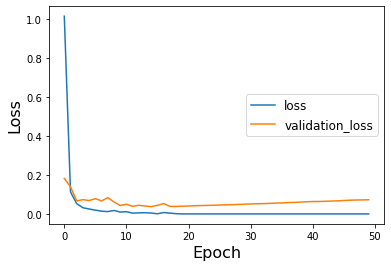

In [8]:
# display loss and validation loss during training
%matplotlib inline
plt.plot(RGBCNN.history['loss'],label='loss')
plt.plot(RGBCNN.history['val_loss'],label='val_loss')

plt.legend(['loss', 'validation_loss'],
           loc='center right',
           fontsize='large')

plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.savefig('ts/RGBModel_norm_mean_std_losses.png', dpi=500)
plt.show()

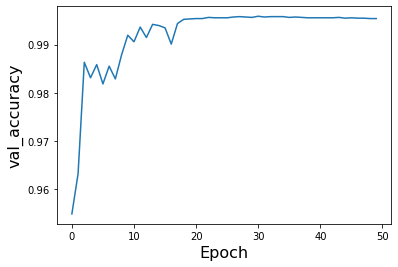

In [9]:
#display validation accuracy during training
%matplotlib inline
plt.plot(RGBCNN.history['val_accuracy'],label='val_accuracy')

plt.xlabel('Epoch', fontsize=16)
plt.ylabel('val_accuracy', fontsize=16)
plt.savefig('ts/RGBModel_norm_mean_std_accuracy.png', dpi=500)
plt.show()

In [10]:
print(RGBCNN.history['val_accuracy'])

[0.9548267722129822, 0.9631862640380859, 0.9863355159759521, 0.983120322227478, 0.9858532547950745, 0.9818342328071594, 0.9855316877365112, 0.9828791618347168, 0.9878627061843872, 0.9919620752334595, 0.9905956387519836, 0.9936500191688538, 0.9914798140525818, 0.9942126870155334, 0.9939715266227722, 0.9934892654418945, 0.9901133179664612, 0.9943734407424927, 0.9952576160430908, 0.9953380227088928, 0.99541836977005, 0.99541836977005, 0.9956595301628113, 0.9955791234970093, 0.9955791234970093, 0.9955791234970093, 0.9957398772239685, 0.9958202838897705, 0.9957398772239685, 0.9956595301628113, 0.9959006309509277, 0.9957398772239685, 0.9958202838897705, 0.9958202838897705, 0.9958202838897705, 0.9956595301628113, 0.9957398772239685, 0.9956595301628113, 0.9955791234970093, 0.9955791234970093, 0.9955791234970093, 0.9955791234970093, 0.9955791234970093, 0.9956595301628113, 0.995498776435852, 0.9955791234970093, 0.995498776435852, 0.995498776435852, 0.99541836977005, 0.99541836977005]


TRAINING FIRST GRAY MODELL

In [11]:
epochs = 50

# learning rate updater
learning_rate = LearningRateScheduler(lambda x: 1e-2 * 0.95 ** (x + epochs), verbose=1)

In [12]:
#saving weights
best_weights_filepath = 'ts/sulyok/w_1_dataset_ts_gray_norm_mean_std.h5'

In [13]:
#training
with h5py.File('ts/norm_mean_std_gray_dataset_ts.hdf5', 'r') as f:
    x_train = f['x_train']  # HDF5 dataset
    y_train = f['y_train']  # HDF5 dataset

    x_train = np.array(x_train)  # Numpy array
    y_train = np.array(y_train)  # Numpy array
    
    x_validation = f['x_validation']  # HDF5 dataset
    y_validation = f['y_validation']  # HDF5 dataset

    x_validation = np.array(x_validation)  # Numpy array
    y_validation = np.array(y_validation)  # Numpy array


# Preparing classes to be passed into the model
y_train = to_categorical(y_train, num_classes=43)
y_validation = to_categorical(y_validation, num_classes=43)

# save best weights
best_weights = ModelCheckpoint(filepath=best_weights_filepath,
                                save_weights_only=True,
                                monitor='val_accuracy',
                                mode='max',
                                save_best_only=True,
                                period=1,
                                verbose=1)

# Training First gray model
GRAY1CNN = modelGRAY1.fit(x_train, y_train,
                    batch_size=50,
                    epochs=epochs,
                    validation_data=(x_validation, y_validation),
                    callbacks=[learning_rate, best_weights],
                    verbose=1)


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.0007694497527671316.
726/726 [==============================] - 42s 54ms/step - loss: 1.5062 - accuracy: 0.5754 - val_loss: 0.2628 - val_accuracy: 0.9244

Epoch 00001: val_accuracy improved from -inf to 0.92444, saving model to ts/sulyok\w_1_dataset_ts_gray_norm_mean_std.h5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0007309772651287749.
726/726 [==============================] - 37s 51ms/step - loss: 0.3255 - accuracy: 0.8969 - val_loss: 0.1210 - val_accuracy: 0.9656

Epoch 00002: val_accuracy improved from 0.92444 to 0.96560, saving model to ts/sulyok\w_1_dataset_ts_gray_norm_mean_std.h5
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.000694428401872336.
726/726 [==============================] - 37s 51ms/step - loss: 0.2007 - accuracy: 0.9372 - val_loss: 0.0698 - val_accuracy: 0.9795

Epoch 00003: val_accuracy improved from 0.96560 to 0.97950, saving mode

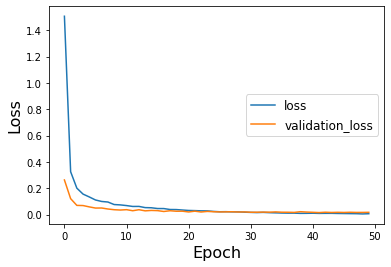

In [14]:
# display loss and validation loss during training
%matplotlib inline
plt.plot(GRAY1CNN.history['loss'],label='loss')
plt.plot(GRAY1CNN.history['val_loss'],label='val_loss')

plt.legend(['loss', 'validation_loss'],
           loc='center right',
           fontsize='large')

plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.savefig('ts/GrayModel1_norm_mean_std_losses.png', dpi=500)
plt.show()

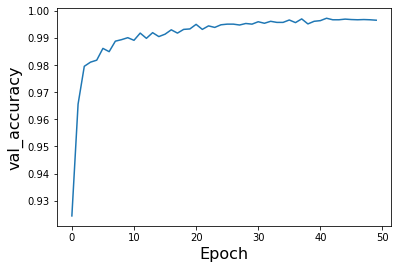

In [15]:
#display validation accuracy during training
%matplotlib inline
plt.plot(GRAY1CNN.history['val_accuracy'],label='val_accuracy')

plt.xlabel('Epoch', fontsize=16)
plt.ylabel('val_accuracy', fontsize=16)
plt.savefig('ts/GrayModel1_norm_mean_std_accuracy.png', dpi=500)
plt.show()

In [16]:
print(GRAY1CNN.history['val_accuracy'])

[0.9244433641433716, 0.9655976295471191, 0.9795032739639282, 0.9810304641723633, 0.9817538857460022, 0.9860943555831909, 0.9848886728286743, 0.9887468814849854, 0.989309549331665, 0.990032970905304, 0.9890683889389038, 0.9917209148406982, 0.9897918105125427, 0.9918816685676575, 0.9904348254203796, 0.9913190007209778, 0.9929265975952148, 0.9917209148406982, 0.9930873513221741, 0.9932481050491333, 0.9949361085891724, 0.9930873513221741, 0.9943734407424927, 0.993810772895813, 0.9947753548622131, 0.9950164556503296, 0.9950164556503296, 0.9946949481964111, 0.9952576160430908, 0.9950164556503296, 0.9959006309509277, 0.9953380227088928, 0.996061384677887, 0.9956595301628113, 0.9956595301628113, 0.9965437054634094, 0.9955791234970093, 0.9969455599784851, 0.9950968623161316, 0.996061384677887, 0.9963025450706482, 0.9971867203712463, 0.9966240525245667, 0.9966240525245667, 0.9968652129173279, 0.9967044591903687, 0.9966240525245667, 0.9967044591903687, 0.9966240525245667, 0.9964632987976074]


TRAINING SECOND GRAY MODELL

In [17]:
epochs = 50

# learning rate  updater
learning_rate = LearningRateScheduler(lambda x: 1e-2 * 0.95 ** (x + epochs), verbose=1)

In [18]:
#saving weights
best_weights_filepath = 'ts/sulyok/w_2_dataset_ts_gray_norm_mean_std.h5'

In [19]:
#training
with h5py.File('ts/norm_mean_std_gray_dataset_ts.hdf5', 'r') as f:
    x_train = f['x_train']  # HDF5 dataset
    y_train = f['y_train']  # HDF5 dataset

    x_train = np.array(x_train)  # Numpy array
    y_train = np.array(y_train)  # Numpy array

    x_validation = f['x_validation']  # HDF5 dataset
    y_validation = f['y_validation']  # HDF5 dataset

    x_validation = np.array(x_validation)  # Numpy array
    y_validation = np.array(y_validation)  # Numpy array


# Transforming them from vectors to binary matrices
y_train = to_categorical(y_train, num_classes=43)
y_validation = to_categorical(y_validation, num_classes=43)


#save best weights
best_weights = ModelCheckpoint(filepath=best_weights_filepath,
                                save_weights_only=True,
                                monitor='val_accuracy',
                                mode='max',
                                save_best_only=True,
                                period=1,
                                verbose=1)

# Training Second gray model
GRAY2CNN = modelGRAY2.fit(x_train, y_train,
                    batch_size=50,
                    epochs=epochs,
                    validation_data=(x_validation, y_validation),
                    callbacks=[learning_rate, best_weights],
                    verbose=1)

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.0007694497527671316.
726/726 [==============================] - 19s 25ms/step - loss: 1.6643 - accuracy: 0.5416 - val_loss: 0.7306 - val_accuracy: 0.7935

Epoch 00001: val_accuracy improved from -inf to 0.79351, saving model to ts/sulyok\w_2_dataset_ts_gray_norm_mean_std.h5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0007309772651287749.
726/726 [==============================] - 18s 24ms/step - loss: 0.8861 - accuracy: 0.7412 - val_loss: 0.5177 - val_accuracy: 0.8565

Epoch 00002: val_accuracy improved from 0.79351 to 0.85652, saving model to ts/sulyok\w_2_dataset_ts_gray_norm_mean_std.h5
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.000694428401872336.
726/726 [==============================] - 18s 24ms/step - loss: 0.7291 - accuracy: 0.7844 - val_loss: 0.4158 - val_accuracy: 0.8826

Epoch 00003: val_accuracy improved from 0.85652 to 0.88265, saving mode

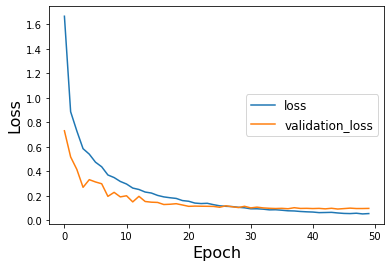

In [20]:
# display loss and validation loss during training
%matplotlib inline
plt.plot(GRAY2CNN.history['loss'],label='loss')
plt.plot(GRAY2CNN.history['val_loss'],label='val_loss')

plt.legend(['loss', 'validation_loss'],
           loc='center right',
           fontsize='large')

plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.savefig('ts/GrayModel2_norm_mean_std_losses.png', dpi=500)
plt.show()#

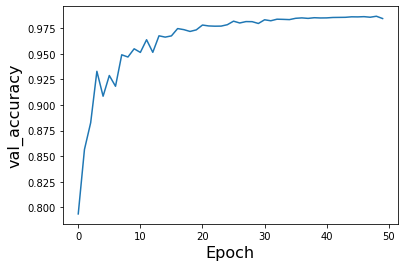

In [21]:
#display validation accuracy during training
%matplotlib inline
plt.plot(GRAY2CNN.history['val_accuracy'],label='val_accuracy')

plt.xlabel('Epoch', fontsize=16)
plt.ylabel('val_accuracy', fontsize=16)
plt.savefig('ts/GrayModel2_norm_mean_std_accuracy.png', dpi=500)
plt.show()

In [22]:
print(GRAY2CNN.history['val_accuracy'])

[0.7935053706169128, 0.856522798538208, 0.8826460838317871, 0.9329636096954346, 0.908608615398407, 0.9288642406463623, 0.9183345437049866, 0.9491198658943176, 0.9469496011734009, 0.9549875259399414, 0.9514508247375488, 0.9638292789459229, 0.9515312314033508, 0.9676874876022339, 0.9664013981819153, 0.9676070809364319, 0.974760890007019, 0.9737159609794617, 0.9719476103782654, 0.9734748005867004, 0.9782171845436096, 0.9773330092430115, 0.9770918488502502, 0.9771722555160522, 0.9785386919975281, 0.9819950461387634, 0.9802266955375671, 0.981593132019043, 0.981512725353241, 0.9797443747520447, 0.9833614826202393, 0.9823969006538391, 0.983924150466919, 0.9837633371353149, 0.9835222363471985, 0.9848082661628723, 0.9852101802825928, 0.9847279191017151, 0.985370934009552, 0.9851298332214355, 0.9852101802825928, 0.9856120944023132, 0.9856924414634705, 0.9857728481292725, 0.9862551093101501, 0.9861747622489929, 0.9864158630371094, 0.9858532547950745, 0.9868177771568298, 0.9845671653747559]


Model evaluations

In [23]:
with h5py.File('ts/norm_mean_std_rgb_dataset_ts.hdf5', 'r') as f:
    x_test = f['x_test']  # HDF5 dataset
    y_test = f['y_test']  # HDF5 dataset
    
    x_test = np.array(x_test)  # Numpy array
    y_test = np.array(y_test)  # Numpy array
    
# Preparing classes to be passed into the model
y_test = to_categorical(y_test, num_classes=43)

In [24]:
modelRGB.load_weights('ts/sulyok/w_1_dataset_ts_rgb_norm_mean_std.h5')
modelRGB.evaluate(x_test,y_test)

98/98 [==============================] - 0s 2ms/step - loss: 0.0450 - accuracy: 0.9949


[0.0449858196079731, 0.9948569536209106]

GRAY1 modell

In [12]:
with h5py.File('ts/norm_gray_dataset_ts.hdf5', 'r') as f:
    x_test = f['x_test']  # HDF5 dataset
    y_test = f['y_test']  # HDF5 dataset
    
    x_test = np.array(x_test)  # Numpy array
    y_test = np.array(y_test)  # Numpy array
    
# Preparing classes to be passed into the model
#y_test = to_categorical(y_test, num_classes=43)

In [10]:
modelGRAY1.load_weights('ts/sulyok/w_1_dataset_ts_gray_norm.h5')
modelGRAY1.evaluate(x_test,y_test)

98/98 [==============================] - 1s 12ms/step - loss: 0.0061 - accuracy: 0.9987


[0.006083777640014887, 0.99871426820755]

In [27]:
modelGRAY2.load_weights('ts/sulyok/w_2_dataset_ts_gray_norm_mean_std.h5')
modelGRAY2.evaluate(x_test,y_test)

98/98 [==============================] - 1s 7ms/step - loss: 0.0868 - accuracy: 0.9855


[0.08680572360754013, 0.985535204410553]